# Intrusion Detection con Multi-Layer Perceptron (MLP)
In questo notebook utilizzeremo una rete neurale MLP per classificare i flussi di traffico di rete come benigni o dannosi. Il modello di MLP restituisce un valore compreso tra 0 e 1, che rappresenta la probabilità che il flusso in ingresso sia dannoso. Usiamo una soglia fissata a 0,5 per determinare se il flusso di rete è dannoso o meno.
Addestreremo un modello di Logistic Regression con traffico di rete benigno e quattro classi di attacchi DDoS dal dataset CIC-DDoS2019 dell’Università del New Brunswick. Il traffico di rete è stato precedentemente pre-elaborato in modo che i pacchetti siano raggruppati in flussi di traffico bidirezionali utilizzando la 5-tupla (IP sorgente, IP destinazione, porta sorgente, porta destinazione, protocollo). Ogni flusso è rappresentato da 21 features (attributi) dell’header dei pacchetti calcolate da un massimo di 1000 pacchetti:

| Features           | Multi-Layer Perceptron          |
|---------------------|--------------------|
| timestamp (mean IAT)  <br> packet_length (mean) <br> IP_flags_df (sum) <br> IP_flags_mf (sum) <br> IP_flags_rb (sum) <br> IP_frag_off (sum) <br> protocols (mean) <br> TCP_length (mean) <br> TCP_flags_ack (sum) <br> TCP_flags_cwr (sum) <br> TCP_flags_ece (sum) <br> TCP_flags_fin (sum) <br> TCP_flags_push (sum) <br> TCP_flags_res (sum) <br> TCP_flags_reset (sum) <br> TCP_flags_syn (sum) <br> TCP_flags_urg (sum) <br> TCP_window_size (mean) <br> UDP_length (mean) <br> ICMP_type (mean) <br> Packets (counter) <br>| <img src="./MLP.jpg" width="100%">  |

In [21]:
# Author: Roberto Doriguzzi-Corin
# Project: Corso di Algoritmi di Machine Learning per la rilevazione di attacchi informatici
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Import necessary libraries

import numpy as np
import glob
import h5py
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from keras.models import Sequential
from keras.layers import Dense, Input
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD,Adam
import time
from util_functions import *
DATASET_FOLDER = "../Dataset"

# Conversione delle labels
Nel nostro dataset, le labels assegnate ai flussi hanno un valore numerico che varia da 0 (benigno) a 4 (abbiamo 4 tipi di attacchi). In questo notebook, noi ci occupiamo di classificazione binaria (0/1, cioe' benigno/malevolo) e per cui, dopo aver caricato il dataset dai files, convertiamo tutte le labels > 0 in 1. 

Questo vuol dire che non ci interessa capire il tipo di attacco, ma solo se c'e' un attacco o meno.

In [22]:
# Load training, validation and test sets
feature_names = get_feature_names()
target_names = ['benign', 'dns',  'syn', 'udplag', 'webddos'] 

X_train, y_train = load_dataset(DATASET_FOLDER + "/*" + '-train.hdf5')
y_train = np.array([1 if y > 0 else 0 for y in y_train]) # classificazione binaria, tutte le labels diverse da 0 le trasformiamo in 1

X_val, y_val = load_dataset(DATASET_FOLDER + "/*" + '-val.hdf5')
y_val = np.array([1 if y > 0 else 0 for y in y_val]) # classificazione binaria, tutte le labels diverse da 0 le trasformiamo in 1

X_test, y_test = load_dataset(DATASET_FOLDER + "/*" + '-test.hdf5')
y_test = np.array([1 if y > 0 else 0 for y in y_test]) # classificazione binaria, tutte le labels diverse da 0 le trasformiamo in 1

# Implementazione del modello
Nella prossima cella, implementiamo il modello MLP. 
Il modello e' creato partendo dal modello di Logistic regression al quale aggiungiamo un numero configurabile di ```hidden_layers``` e ```hidden_units```.

In [23]:
# MLP model
def create_model(hidden_layers=0, hidden_units=1):
    model = Sequential(name  = "mlp")
    # Questo e' l'input layer. In questo caso abbiamo 21 features
    model.add(Input(shape=(21,)))
    
    # I seguenti sono gli hidden layers
    for layer in range(hidden_layers):
        model.add(Dense(hidden_units, activation='relu'))
    
    # Infine l'output layer
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    print (model.summary())
    return model

# Model training con Grid Search e Early Stopping
Il codice nella cella seguente esegue la configurazione automatica del modello MLP con la strategia ```grid search```.
Grid Search è una tecnica di ottimizzazione dei parametri dei modelli di Deep Learning (ma anche di modelli di Machine Learning) che consiste nella ricerca sistematica della combinazione ottimale di parametri (per esempio, hidden layers e hidden units (neuroni)), valutando le prestazioni di un modello su una griglia di possibili valori di questi parametri. La griglia dei parametri è  definita dal programmatore. 

Il tuo compito e' di inserire alcuni valori nella griglia sotto e di far partire l'addestramento del modello MLP.
Assegna anche un valore di ```PATIENCE``` assegnando un numero intero alla variabile ```PATIENCE```.

In [24]:
# Create a KerasClassifier based on the create_model function
model = KerasClassifier(build_fn=create_model, batch_size=100, verbose=1)

### Inserisci alcuni valori interi separati da virgola tra le parentesi quadre ####
param_grid = {
    'hidden_layers' : [4],
    'hidden_units' : [4,8,16]
}
###########################################################

### Stabilisci il valore di PATIENCE (per esempio 10) ###
PATIENCE = 20
###########################################################

# Perform grid search with 5-fold cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)

### Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE, restore_best_weights=True)

start_time = time.time()
grid_result = grid.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks= [early_stopping])
stop_time = time.time()

# Total training time
print("Total training time (sec): ", stop_time-start_time)
# Print the best parameters and corresponding accuracy
print("Best parameters found: ", grid_result.best_params_)
print("Best cross-validated accuracy: {:.2f}".format(grid_result.best_score_))

# Salviamo il modello migliore
best_model = grid.best_estimator_.model
best_model.save('./mlp_model.h5')

/var/folders/hv/g5tssjyj43gfwdfvx2cnjt_c0000gn/T/ipykernel_29231/3055432407.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn=create_model, batch_size=100, verbose=1)


Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 4)                 88        
                                                                 
 dense_141 (Dense)           (None, 4)                 20        
                                                                 
 dense_142 (Dense)           (None, 4)                 20        
                                                                 
 dense_143 (Dense)           (None, 4)                 20        
                                                                 
 dense_144 (Dense)           (None, 1)                 5         
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
5/5 [==============================] - 0s 15ms/s

# Usiamo il modello con dei dati mai visti (test set)

In [ ]:
y_pred = np.squeeze(best_model.predict(X_test, batch_size=32) > 0.5)
print("F1 Score: ", f1_score(y_test,y_pred))

F1 Score:  0.9842931937172775


# Stampiamo la confusion matrix
Questo ci permette di capire dove sbaglia il modello.

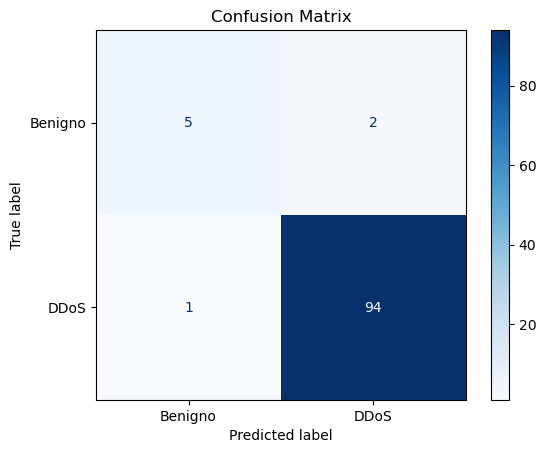

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
np.set_printoptions(precision=2)

y_test_binary = (y_test > 0).astype(int)
y_pred_binary = (y_pred > 0).astype(int)

cm = confusion_matrix(y_test_binary, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Benigno', 'DDoS'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()